In [1]:
import os.path
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.animation import FuncAnimation
import yt
import glob
import pandas as pd
import math
import scipy.integrate as integrate
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['figure.dpi'] = 400

In [2]:
def tophat(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 0.5 * width):
        return amplitude
    else:
        return 0.0

In [3]:
def gaussian(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 6 * width):
        return amplitude * math.exp( - ((x - convected_distance) - center) ** 2 / (2 * width ** 2))
    else:
        return 0.0

In [4]:
def yalla2021(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 6 * width):
        return math.cos(eta * (x-convected_distance)) * amplitude * math.exp( - ((x-convected_distance) - center) ** 2 / (2 * width ** 2))
    else:
        return 0.0

In [5]:
def tophatfv(func,x,dx,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs(abs((x-convected_distance) - center) - width / 2) < dx / 2) :
        return amplitude * (width / 2 - abs((x-convected_distance) - center) + dx / 2) / dx
    elif (abs((x-convected_distance) - center) < width / 2) :
        return amplitude
    else :
        return 0.0

In [6]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [7]:
def exact_sol_cell_average_scipy(func,x,dx,center,amplitude,width,eta,t) :
    integral = integrate.quad(func,x-dx/2,x+dx/2,args=(center,amplitude,width,eta,t))
    return integral[0]/dx

In [8]:
def exact_sol_cell_average_GLQ(func,x,dx,center,amplitude,width,eta,t) :
    w_i = [0.5555555556, 0.8888888889, 0.5555555556]
    dx_i = [-0.7745966692, 0, 0.7745966692]
    s = 0.0
    for i in range(len(w_i)) :
        s += w_i[i] * func(x + dx_i[i]*dx/2, center, amplitude, width, eta, t)
    return s/2

In [11]:
color_list = [
    "#EE2E2F",
    "#008C48",
    "#185AA9",
    "#F47D23",
    "#662C91",
    "#A21D21",
    "#B43894",
    "#010202",
]
linestyle_list = [
    "solid",
    "dashed",
    "dotted",
    "dashdot"
]
linewidth_list = [
    1.5,
    0.5
]

In [12]:
def postprocess_dist(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting,line_configuration):
    
    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                # Load plt files
                plt_files = natural_sort(glob.glob(os.path.join(case_dir, "plt*")))
                
                ds = yt.load(plt_files[idx])
                ray = ds.ortho_ray(0, (0, 0))
                srt = np.argsort(ray["x"])
                df = pd.DataFrame({f: np.array(ray[f][srt]) for f in ["x","temperature"]})
                t = ds.current_time.value.flatten()[0]
                df["time"] = t
                df["dx"] = [ray.fwidth[i][0].value.flatten()[0] for i in range(len(df["x"].values))]
                
                # Plot scalar distribution
                if plotting == True:
                    if line_configuration == 1:
                        ax.plot(df["x"].values, df["temperature"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                    else:
                        ax.plot(df["x"].values, df["temperature"].values, label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
    return t, df["x"].values, df["temperature"].values
            

In [175]:
def postprocess_error(case,t,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,plotting,line_configuration):
    
    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                error_file = os.path.join(case_dir,'error.log')
                with open(error_file) as f:
                    lines = f.readlines()
                    error_levels = len(lines[1].split())-1
                    time = [float(line.split()[0]) for line in lines]
                    idx = time.index(min(time, key=lambda x:abs(x-t)))+1
                    
                    errors = []

                    for level in reversed(range(error_levels)):
                        errors.append([float(line.split()[level+1]) for line in lines][:idx])

                    for level in range(error_levels):
                        if line_configuration == 1:
                            ax.plot(time[:idx], errors[level], label=f'{method}; nx = {grid_size}; grid type = {grid_type}', color=line_colors[i_grid_size], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_method])
                        else:
                            ax.plot(time[:idx], errors[level], label=f'{method}; nx = {grid_size}; grid type = {grid_type}', color=line_colors[i_method], linewidth=line_widths[i_grid_type], linestyle=line_styles[i_grid_size])
    
    return time[:idx], errors
            

In [14]:
def postprocess_convergence(case,idx,rootdir,methods,grid_types,grid_sizes,
                ax,line_styles,line_colors,line_widths,line_configuration):
    
    dx_list = [1.0/grid_size for grid_size in grid_sizes]

    i_method = -1
    for method in methods:
        i_method += 1
        i_grid_type = -1
        for grid_type in grid_types:
            i_grid_type += 1
            i_grid_size = -1
            
            error_list = []
            
            for grid_size in grid_sizes:
                i_grid_size += 1

                case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')

                error_file = os.path.join(case_dir,'error.log')
                
                with open(error_file) as f:
                    lines = f.readlines()
                    error = float(lines[-1].split()[-1])
                    
                error_list.append(error)
        if line_configuration == 1:
            ax.plot(dx_list, error_list, label=f'{method}; grid type = {grid_type}',linestyle=line_styles[i_method],linewidth=line_widths[i_grid_type],color='black')
        else :
            ax.plot(dx_list, error_list, label=f'{method}; grid type = {grid_type}',linestyle=line_styles[i_method],linewidth=line_widths[i_grid_type],color=line_colors[i_method])

                

# Animation to show scalar advection case

In [235]:
root_dir = '/Users/dbeckers/scalar_advection'

In [272]:
center = 0.25
amplitude = 1.0
width = 0.0251646060
# width = 0.05
# width = 0.01
eta = 226.1946710304
# t_final = 0.5
function = yalla2021

In [273]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 20

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 1), ylim=(-1.3, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')
line, = ax.plot([], [], color='red',linewidth=1)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    t = i/(n_frames-1)*0.5
    scalar_exact = [function(x_i,center,amplitude,width,eta,t) for x_i in x_exact]
    line.set_data(x_exact, scalar_exact)
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=100, blit=True)
anim.save('1-scalar_advection_case.gif',dpi=300)

In [274]:
anim

# Uniform grid: different methods with nx = 512

### Initial timestep

In [239]:
lw_exact = 0.5
ls_exact = 'dashed'

yt : [INFO     ] 2022-08-07 20:42:33,353 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 20:42:33,357 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:42:33,361 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:42:33,366 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

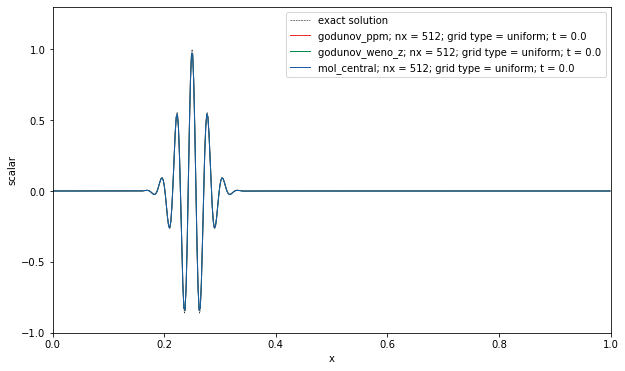

In [240]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',0,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('3-scalar_advection_uniform_initial.png',dpi=300)

### Final timestep

yt : [INFO     ] 2022-08-07 20:47:25,580 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-07 20:47:25,583 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:47:25,593 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:47:25,600 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

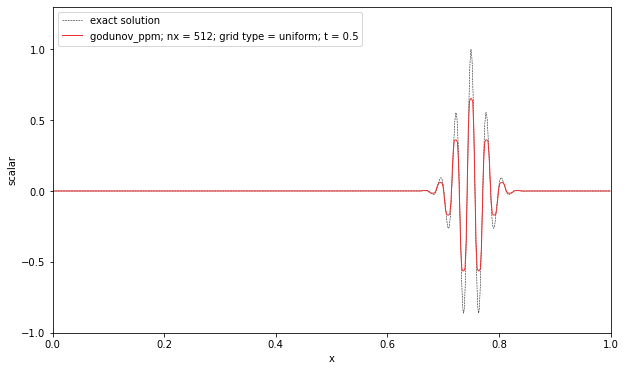

In [241]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('4a-scalar_advection_uniform_final_godunov_ppm.png',dpi=300)

In [275]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 9

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 1), ylim=(-1, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')

lines = []
line1 = ax.plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
lines.append(line1)
line2 = ax.plot([],[],color='red',label='godunov_ppm; nx = 512; grid type = uniform;',linewidth=1.0,linestyle='solid')[0]
lines.append(line2)
ax.legend(loc='upper left')

t_list = [0.0 for i in range(n_frames)]

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    t,x,s = postprocess_dist('yalla2021/eta_2',i,root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],False,2)
    t_list[i] = t
    lines[1].set_data(x,s)
    scalar_exact = [function(x_i,center,amplitude,width,eta,t) for x_i in x_exact]
    lines[0].set_data(x_exact,scalar_exact)
    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=200, blit=True)
anim.save('4a-scalar_advection_uniform_final_godunov_ppm.gif',dpi=300)

yt : [INFO     ] 2022-08-07 20:56:46,038 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 20:56:46,040 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:56:46,046 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:56:46,051 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-07 20:56:48,249 Parameters: current_time              = 0.0625
yt : [INFO     ] 2022-08-07 20:56:48,252 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:56:48,257 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:56:48,261 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
yt : [INFO     ] 2022-08-07 20:56:50,191 Parameters: current_time              = 0.125
yt : [INFO     ] 2022-08-07 20:56:50,194 Parameters: domain_dimensions         =

In [243]:
# anim

yt : [INFO     ] 2022-08-07 20:48:24,734 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-07 20:48:24,736 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:48:24,759 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:48:24,769 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

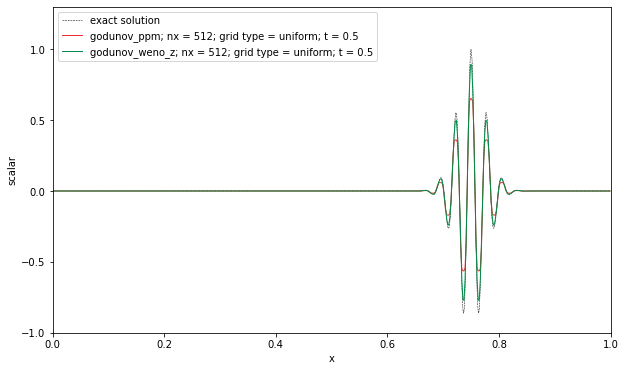

In [244]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm','godunov_weno_z'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('4b-scalar_advection_uniform_final_godunov_ppm_weno_z.png',dpi=300)

yt : [INFO     ] 2022-08-07 20:48:32,566 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-08-07 20:48:32,568 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:48:32,572 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:48:32,580 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

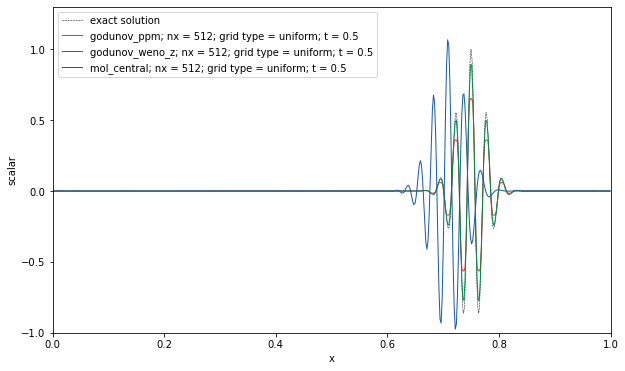

In [245]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('4c-scalar_advection_uniform_final_godunov_ppm_weno_z_mol_central.png',dpi=300)

### Errors

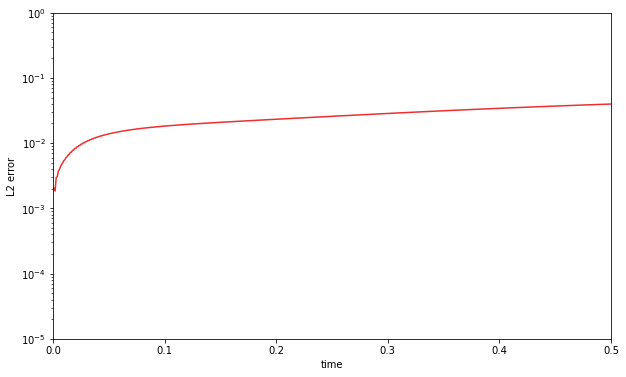

In [246]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0.5,root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_xlim([0,0.5])
ax.set_ylim([1e-5,1])
ax.set_yscale('log')

fig.savefig('5a-scalar_advection_uniform_error_godunov_ppm.png',dpi=300)

In [276]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 0.5), ylim=(1e-5,1))
ax.set_xlabel('t')
ax.set_ylabel('L2 error')
ax.set_yscale('log')

line = ax.plot([],[],color='red',label='godunov_ppm; nx = 512; grid type = uniform;',linewidth=1.0,linestyle='solid')[0]

def init():
    line.set_data([],[])
    return line,
def animate(i):
    t,e = postprocess_error('yalla2021/eta_2',t_list[i],root_dir,['godunov_ppm'],['uniform'],[512],
                 ax,linestyle_list,color_list,linewidth_list,False,1)
    line.set_data(t,e)
    return line,

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t_list), interval=200, blit=True)
anim.save('5a-scalar_advection_uniform_error_godunov_ppm.gif',dpi=300)

In [248]:
# anim

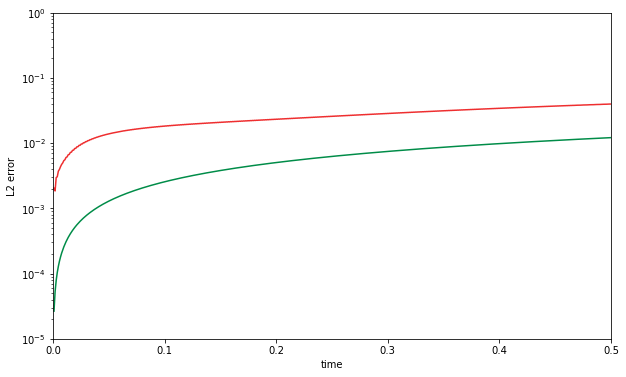

In [249]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0.5,root_dir,['godunov_ppm','godunov_weno_z'],['uniform'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')

fig.savefig('5b-scalar_advection_uniform_error_godunov_ppm_weno_z.png',dpi=300)

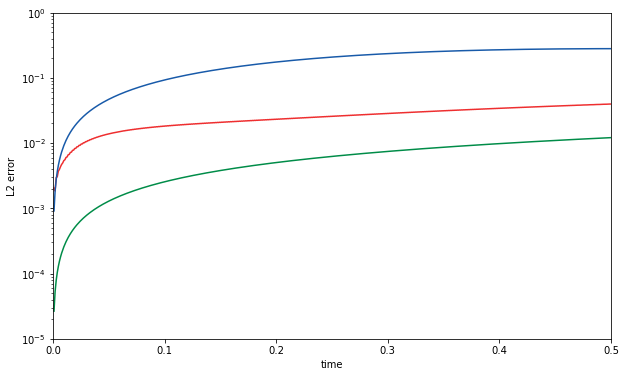

In [250]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0.5,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')

fig.savefig('5c-scalar_advection_uniform_error_godunov_ppm_weno_z_mol_central.png',dpi=300)

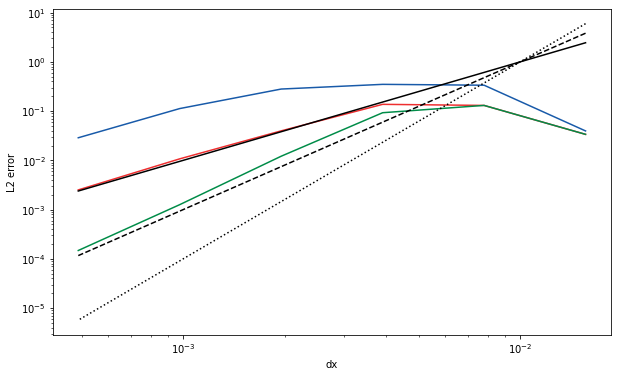

In [251]:
grid_sizes = [64,128,256,512,1024,2048]
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_convergence('yalla2021/eta_2',0,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],grid_sizes,
                 ax,['solid','solid','solid'],color_list,linewidth_list,2)
dx_list = [1.0/grid_size for grid_size in grid_sizes]
ax.plot(dx_list,[1e4*dx**2 for dx in dx_list],label='dx^2',linestyle='solid',color='black')
ax.plot(dx_list,[1e6*dx**3 for dx in dx_list],label='dx^3',linestyle='dashed',color='black')
ax.plot(dx_list,[1e8*dx**4 for dx in dx_list],label='dx^4',linestyle='dotted',color='black')

ax.set_xlabel('dx')
ax.set_ylabel('L2 error')
ax.set_xscale('log')
ax.set_yscale('log')


fig.savefig('6-scalar_advection_uniform_error_convergence_all.png',dpi=300)

# Fine-to-coarse grid: different methods with nx = 512

yt : [INFO     ] 2022-08-08 07:19:48,912 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-08 07:19:48,916 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-08 07:19:48,921 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-08 07:19:48,926 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

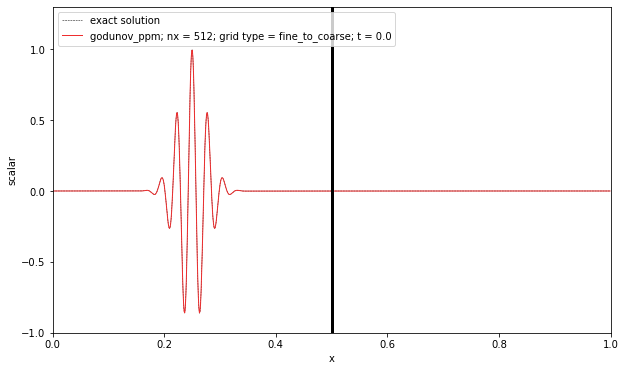

In [288]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.0) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',0,root_dir,['godunov_ppm'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')
ax.axvline(0.5,-1,1,color="black",linewidth=3)

fig.savefig('7aa-scalar_advection_refined_initial_godunov_ppm.png',dpi=300)

yt : [INFO     ] 2022-08-07 20:50:48,025 Parameters: current_time              = 0.5004882299999965
yt : [INFO     ] 2022-08-07 20:50:48,030 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:50:48,038 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:50:48,044 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_cont

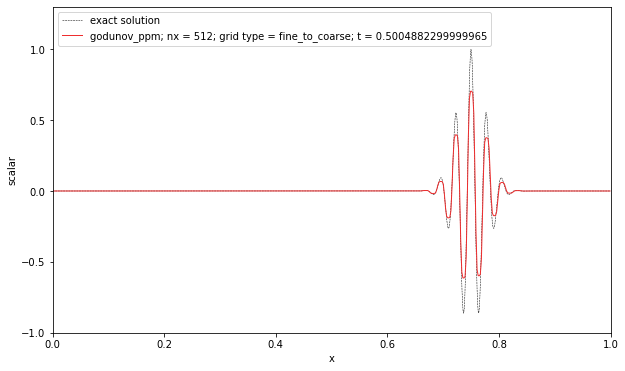

In [252]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('7a-scalar_advection_refined_final_godunov_ppm.png',dpi=300)

MovieWriter ffmpeg unavailable; using Pillow instead.
yt : [INFO     ] 2022-08-07 20:57:14,436 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 20:57:14,438 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:57:14,446 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:57:14,449 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/

yt : [INFO     ] 2022-08-07 20:57:35,522 Parameters: current_time              = 0.15624998399999937
yt : [INFO     ] 2022-08-07 20:57:35,526 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:57:35,530 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:57:35,536 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_con

yt : [INFO     ] 2022-08-07 20:57:55,635 Parameters: current_time              = 0.3124999679999981
yt : [INFO     ] 2022-08-07 20:57:55,637 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:57:55,642 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:57:55,646 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_cont

yt : [INFO     ] 2022-08-07 20:58:13,130 Parameters: current_time              = 0.46874995199999675
yt : [INFO     ] 2022-08-07 20:58:13,132 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:58:13,136 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:58:13,140 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_con

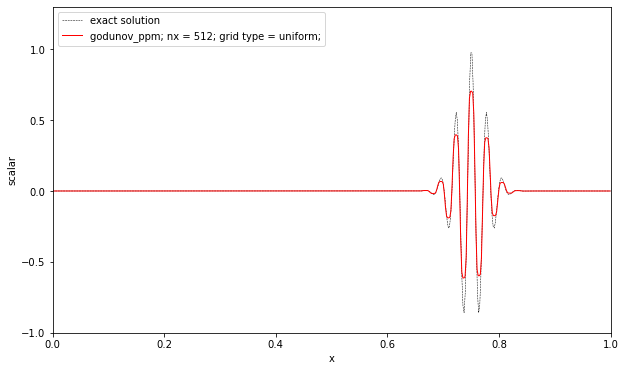

In [277]:
# %%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 18

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 1), ylim=(-1, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')

lines = []
line1 = ax.plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
lines.append(line1)
line2 = ax.plot([],[],color='red',label='godunov_ppm; nx = 512; grid type = uniform;',linewidth=1.0,linestyle='solid')[0]
lines.append(line2)
ax.legend(loc='upper left')

t_list = [0.0 for i in range(n_frames)]

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    t,x,s = postprocess_dist('yalla2021/eta_2',i,root_dir,['godunov_ppm'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],False,2)
    t_list[i] = t
    lines[1].set_data(x,s)
    scalar_exact = [function(x_i,center,amplitude,width,eta,t) for x_i in x_exact]
    lines[0].set_data(x_exact,scalar_exact)
    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=200, blit=True)
anim.save('7a-scalar_advection_refined_final_godunov_ppm.gif',dpi=300)

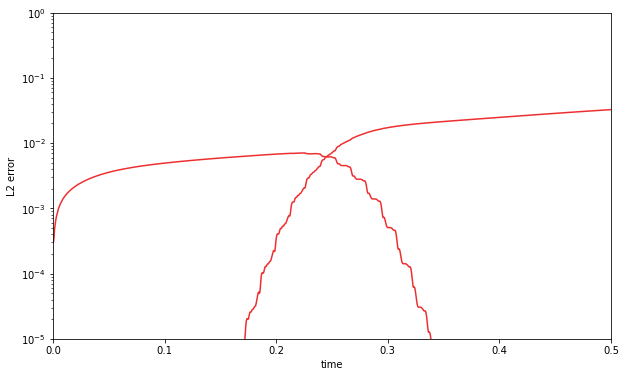

In [254]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0.5,root_dir,['godunov_ppm'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_xlim([0,0.5])

ax.set_yscale('log')

fig.savefig('8a-scalar_advection_refined_error_godunov_ppm.png',dpi=300)

In [278]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 0.5), ylim=(1e-5,1))
ax.set_xlabel('t')
ax.set_ylabel('L2 error')
ax.set_yscale('log')

line1 = ax.plot([],[],color='red',label='godunov_ppm; nx = 512; grid type = fine_to_coarse;',linewidth=1.0,linestyle='solid')[0]
line2 = ax.plot([],[],color='red',linewidth=1.0,linestyle='solid')[0]
lines = [line1,line2]

def init():
    lines[0].set_data([],[])
    lines[1].set_data([],[])
    return lines
def animate(i):
    t,e = postprocess_error('yalla2021/eta_2',t_list[i],root_dir,['godunov_ppm'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,linewidth_list,False,1)
    lines[0].set_data(t,e[0])
    lines[1].set_data(t,e[1])

    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t_list), interval=200, blit=True)
anim.save('8a-scalar_advection_refined_error_godunov_ppm.gif',dpi=300)

In [256]:
# anim

yt : [INFO     ] 2022-08-07 20:52:12,565 Parameters: current_time              = 0.5004882299999965
yt : [INFO     ] 2022-08-07 20:52:12,568 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:52:12,571 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:52:12,575 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_cont

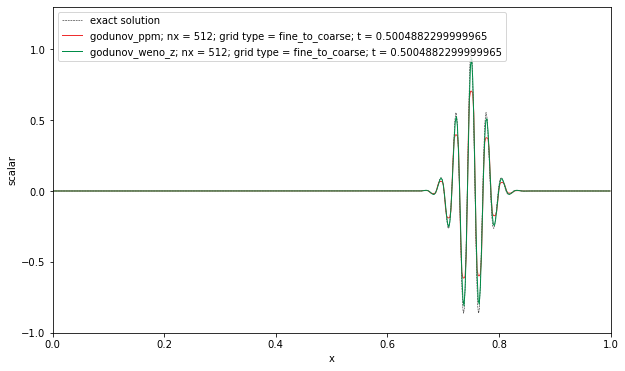

In [257]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm','godunov_weno_z'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('7b-scalar_advection_refined_final_godunov_ppm_weno_z.png',dpi=300)

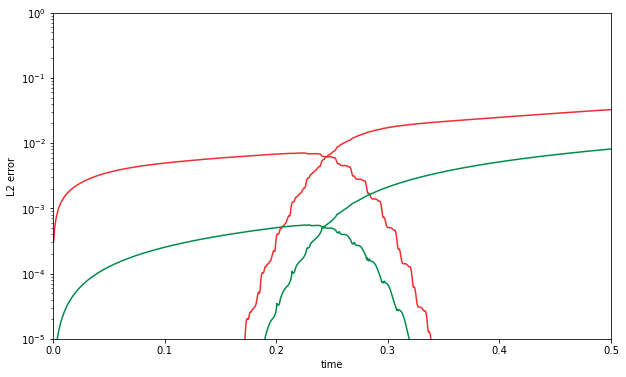

In [282]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0.5,root_dir,['godunov_ppm','godunov_weno_z'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')

fig.savefig('8b-scalar_advection_refined_error_godunov_ppm_weno_z.png',dpi=300)

yt : [INFO     ] 2022-08-07 21:01:49,628 Parameters: current_time              = 0.5004882299999965
yt : [INFO     ] 2022-08-07 21:01:49,630 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 21:01:49,634 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 21:01:49,641 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_cont

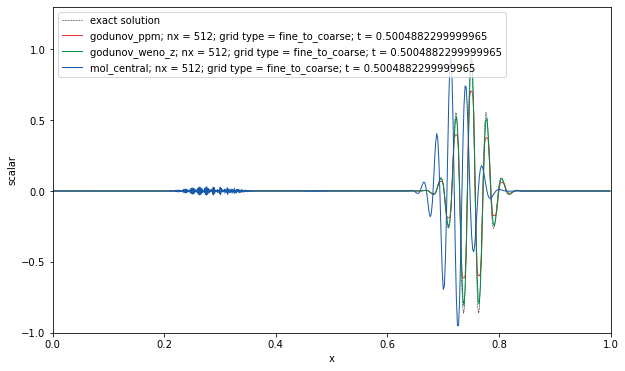

In [283]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('yalla2021/eta_2',-1,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('7c-scalar_advection_refined_final_godunov_ppm_weno_z_mol_central.png',dpi=300)

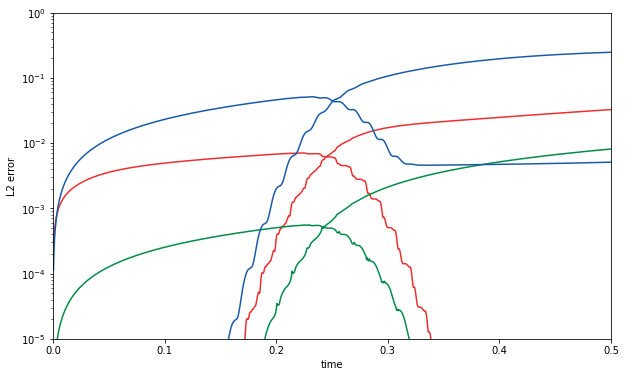

In [284]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('yalla2021/eta_2',0.5,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-5,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')

fig.savefig('8c-scalar_advection_refined_error_godunov_ppm_weno_z_mol_central.png',dpi=300)

MovieWriter ffmpeg unavailable; using Pillow instead.
yt : [INFO     ] 2022-08-07 20:58:35,967 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 20:58:35,969 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:58:35,974 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:58:35,978 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/

yt : [INFO     ] 2022-08-07 20:58:52,282 Parameters: current_time              = 0.15624998399999937
yt : [INFO     ] 2022-08-07 20:58:52,284 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:58:52,287 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:58:52,293 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_con

yt : [INFO     ] 2022-08-07 20:59:08,967 Parameters: current_time              = 0.3124999679999981
yt : [INFO     ] 2022-08-07 20:59:08,970 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:59:08,974 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:59:08,977 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_cont

yt : [INFO     ] 2022-08-07 20:59:25,342 Parameters: current_time              = 0.46874995199999675
yt : [INFO     ] 2022-08-07 20:59:25,344 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:59:25,348 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:59:25,352 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_con

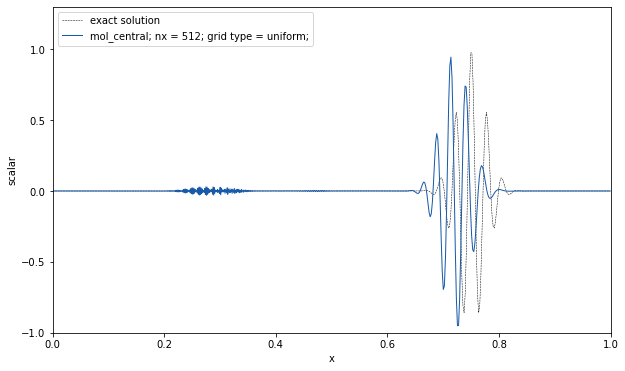

In [279]:
# %%capture
plt.rcParams["animation.html"] = "jshtml"

x_exact = np.linspace(0, 1, num=500)
n_frames = 18

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 1), ylim=(-1, 1.3))
ax.set_xlabel('x')
ax.set_ylabel('scalar')

lines = []
line1 = ax.plot([],[],color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)[0]
lines.append(line1)
line2 = ax.plot([],[],color=color_list[2],label='mol_central; nx = 512; grid type = uniform;',linewidth=1.0,linestyle='solid')[0]
lines.append(line2)
ax.legend(loc='upper left')

t_list = [0.0 for i in range(n_frames)]

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(i):
    t,x,s = postprocess_dist('yalla2021/eta_2',i,root_dir,['mol_central'],['fine_to_coarse'],[512],
                 ax,linestyle_list,[color_list[2]],[1.0],False,2)
    t_list[i] = t
    lines[1].set_data(x,s)
    scalar_exact = [function(x_i,center,amplitude,width,eta,t) for x_i in x_exact]
    lines[0].set_data(x_exact,scalar_exact)
    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=200, blit=True)
anim.save('7d-scalar_advection_refined_final_mol_central.gif',dpi=300)

In [261]:
# anim

In [280]:
%%capture
plt.rcParams["animation.html"] = "jshtml"

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(xlim=(0, 0.5), ylim=(1e-5,1))
ax.set_xlabel('t')
ax.set_ylabel('L2 error')
ax.set_yscale('log')

line1 = ax.plot([],[],color=color_list[2],label='mol_central; nx = 512; grid type = fine_to_coarse;',linewidth=1.0,linestyle='solid')[0]
line2 = ax.plot([],[],color=color_list[2],linewidth=1.0,linestyle='solid')[0]
lines = [line1,line2]

def init():
    lines[0].set_data([],[])
    lines[1].set_data([],[])
    return lines
def animate(i):
    t,e = postprocess_error('yalla2021/eta_2',t_list[i],root_dir,['mol_central'],['fine_to_coarse'],[512],
                 ax,linestyle_list,[color_list[2]],linewidth_list,False,1)
    lines[0].set_data(t,e[0])
    lines[1].set_data(t,e[1])

    return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t_list), interval=200, blit=True)
anim.save('8d-scalar_advection_refined_error_mol_central.gif',dpi=300)

In [264]:
# anim

# Fine-to-coarse grid: tophat

In [266]:
center = 0.25
amplitude = 1.0
# width = 0.0251646060
width = 0.05
# width = 0.01
# eta = 226.1946710304
# t_final = 0.5
function = tophat

yt : [INFO     ] 2022-08-07 20:55:02,522 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-08-07 20:55:02,524 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:55:02,530 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:55:02,540 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421:

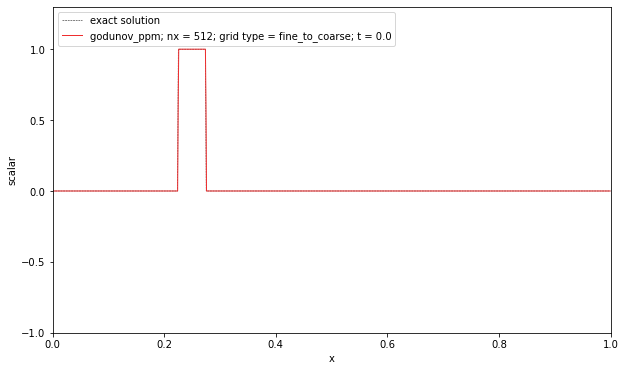

In [267]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('tophat',0,root_dir,['godunov_ppm'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('9a-scalar_advection_refined_error_godunov_ppm_tophat_initial.png',dpi=300)

yt : [INFO     ] 2022-08-07 20:55:06,647 Parameters: current_time              = 0.5004882299999965
yt : [INFO     ] 2022-08-07 20:55:06,649 Parameters: domain_dimensions         = [512   4   4]
yt : [INFO     ] 2022-08-07 20:55:06,656 Parameters: domain_left_edge          = [ 0.         -0.00390625 -0.00390625]
yt : [INFO     ] 2022-08-07 20:55:06,661 Parameters: domain_right_edge         = [1.         0.00390625 0.00390625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_cont

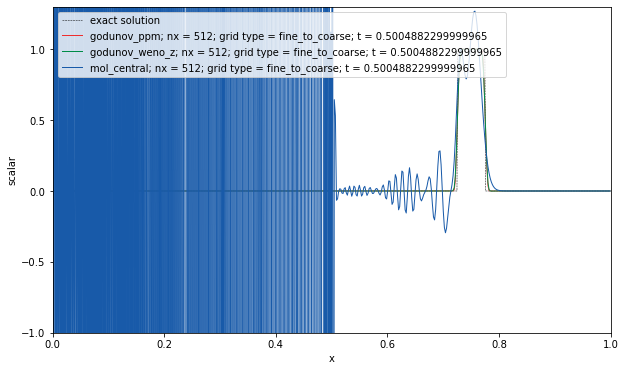

In [268]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.5) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

postprocess_dist('tophat',-1,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['fine_to_coarse'],[512],
                 ax,linestyle_list,color_list,[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0,1])
ax.set_ylim([-1.0,1.3])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('9b-scalar_advection_refined_error_godunov_ppm_weno_z_mol_central_tophat.png',dpi=300)

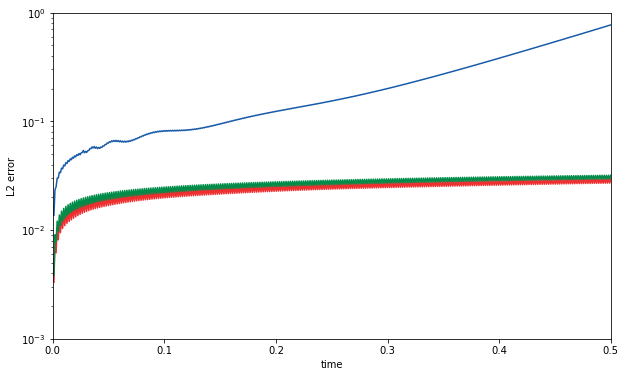

In [269]:
fig, ax = plt.subplots(figsize=(10, 6))
postprocess_error('tophat',0.5,root_dir,['godunov_ppm','godunov_weno_z','mol_central'],['uniform'],[512],
                 ax,linestyle_list,color_list,linewidth_list,True,2)

ax.set_xlabel('time')
ax.set_ylabel('L2 error')
ax.set_ylim([1e-3,1])
ax.set_xlim([0,0.5])
ax.set_yscale('log')

fig.savefig('10-scalar_advection_refined_error_godunov_ppm_weno_z_mol_central_tophat.png',dpi=300)

yt : [INFO     ] 2022-08-07 20:55:18,567 Parameters: current_time              = 0.34375
yt : [INFO     ] 2022-08-07 20:55:18,569 Parameters: domain_dimensions         = [128   4   4]
yt : [INFO     ] 2022-08-07 20:55:18,574 Parameters: domain_left_edge          = [ 0.       -0.015625 -0.015625]
yt : [INFO     ] 2022-08-07 20:55:18,578 Parameters: domain_right_edge         = [1.       0.015625 0.015625]
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: VisibleDeprecationWarning: The requested field name 'x' is ambiguous and corresponds to any one of the following field types:
 {'boxlib', 'gas'}
Please specify the requested field as an explicit tuple (ftype, fname).
Defaulting to '("gas", "x")'.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  finfo = self.ds._get_field_info(field)
/Users/dbeckers/miniconda3/envs/postprocessing/lib/python3.10/site-packages/yt/data_objects/data_containers.py:1421: Visible

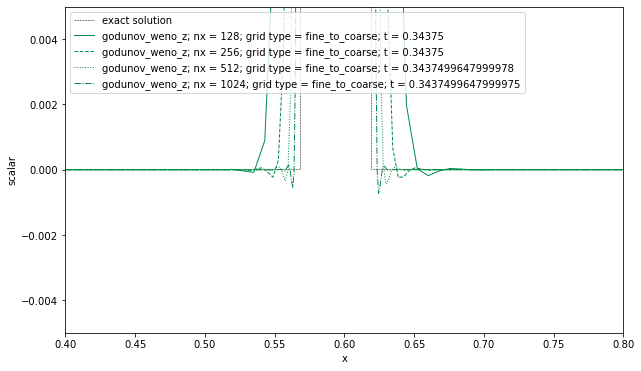

In [270]:
fig, ax = plt.subplots(figsize=(10, 6))

x_exact = np.linspace(0, 1, num=1000)
scalar_exact = [function(x_i,center,amplitude,width,eta,0.34375) for x_i in x_exact]
ax.plot(x_exact,scalar_exact,color='black',label='exact solution',linewidth=lw_exact,linestyle=ls_exact)

t,_,_ = postprocess_dist('tophat',11,root_dir,['godunov_weno_z'],['fine_to_coarse'],[128,256,512,1024],
                 ax,linestyle_list,[color_list[1]],[1.0],True,2)

ax.legend(loc='upper left')
ax.set_xlim([0.4,0.8])
ax.set_ylim([-0.005,0.005])
ax.set_xlabel('x')
ax.set_ylabel('scalar')

fig.savefig('11-scalar_advection_refined_error_godunov_weno_z_tophat_zoom.png',dpi=300)